# Unified Model with Multiple Strategic Agents

Two naive agents

James Yu, 2 September 2025

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(suppress=True)

In [2]:
def M(K, B, R, L, delta):
    """Computes M_{t-1} given B_l \forall l, K_t^l \forall l, 
        R_l \forall l, number of strategic agents L, and delta."""
    # handle the generic structure first, with the correct pairings:
    base = [[B[l_prime].T @ K[l_prime] @ B[l] for l in range(L)] for l_prime in range(L)]
    # then change the diagonals to construct M_{t-1}:
    for l in range(L): base[l][l] = B[l].T @ K[l] @ B[l] + R[l]/delta
    return np.block(base)

def H(B, K, A, L):
    """Computes H_{t-1} given B_l \forall l, K_t^l \forall l, 
        A, and number of strategic agents L."""
    return np.concatenate(tuple(B[l].T @ K[l] @ A for l in range(L)), axis = 0)

def C_l(A, B, K, k, h, L, c, x, n):
    """Computes C_{t-1}^h (displayed as C_{t-1}^l) given A, B_l \forall l, K_t^l \forall l, 
        k_t^l \forall l, a specific naive agent h, number of strategic agents L, 
        c_l \forall l, x_l \forall l, and number of naive agents n"""
    return np.concatenate(tuple(B[l].T @ K[l] @ A @ ((x[h] - x[l]) * np.ones((n, 1))) 
                           + B[l].T @ K[l] @ c[l] 
                           + 0.5 * B[l].T @ k[l].T for l in range(L)), axis = 0)

def E(M_, H_):
    """Computes the generic E_{t-1} given M_{t-1} and H_{t-1}."""
    return np.linalg.inv(M_) @ H_

def F(M_, C_l_, l, n):
    """Computes F_{t-1}^l given M_{t-1}, C_{t-1}^l, 
       specific naive agent l and number of naive agents n."""
    return (np.linalg.inv(M_) @ C_l_)[l*n:(l+1)*n, :] # e.g. l = 0 gives ln = 0, l = 1 gives ln = n, etc

def G(A, B, E_, L, n):
    """Computes the generic G_{t-1} given A, B_l \forall l, 
        E_{t-1}, number of strategic agents L, and number of naive agents n."""
    return A - sum([B[l] @ E_[l*n:(l+1)*n, :] for l in range(L)])
    
def g_l(B, E_, h, x, F_, L, n, c):
    """Computes g_{t-1}^l given B_l \forall l, E_{t-1}^l, 
        a particular naive agent h, x_l \forall l, F_{t-1}^l \forall l, 
        number of strategic agents L, number of naive agents n, and c_h."""
    return - sum([B[l] @ (E_[l*n:(l+1)*n, :] @ ((x[h] - x[l]) * np.ones((n, 1))) + F_[l]) for l in range(L)]) + c[h]

In [3]:
def K_t_minus_1(Q, K, E_, R, G_, L, delta, n):
    return [Q[l] + E_[l*n:(l+1)*n, :].T @ R[l] @ E_[l*n:(l+1)*n, :] 
            + delta * G_.T @ K[l] @ G_ for l in range(L)]

def k_t_minus_1(K, k, G_, g, E_, F_, R, L, delta, n):
    return [2*delta* g[l].T @ K[l] @ G_ + delta * k[l] @ G_ 
            + 2 * F_[l].T @ R[l] @ E_[l*n:(l+1)*n, :] for l in range(L)]

def kappa_t_minus_1(K, k, kappa, g_, F_, R, L, delta):            
    return [-delta * (g_[l].T @ K[l] @ g_[l] + k[l] @ g_[l] - kappa[l]) 
            - (F_[l].T @ R[l] @ F_[l]) for l in range(L)]

In [4]:
def solve(K_t, k_t, kappa_t, A, B, delta, n, L, Q, R, x, c, tol = 300):
    historical_K = [K_t]
    historical_k = [k_t]
    historical_kappa = [kappa_t]
    max_distances = defaultdict(list)
    counter = 0
    while True:
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        K_new = K_t_minus_1(Q, K_t, E_, R, G_, L, delta, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        k_new = k_t_minus_1(K_t, k_t, G_, g, E_, F_, R, L, delta, n)
        kappa_new = kappa_t_minus_1(K_t, k_t, kappa_t, g, F_, R, L, delta)
        cd_K = [np.max(np.abs(K_t[l] - K_new[l])) for l in range(L)]
        cd_k = [np.max(np.abs(k_t[l] - k_new[l])) for l in range(L)]
        cd_kappa = [np.max(np.abs(kappa_t[l] - kappa_new[l])) for l in range(L)]
        K_t = K_new
        k_t = k_new
        kappa_t = kappa_new
        historical_K.insert(0, K_t)
        historical_k.insert(0, k_t)
        historical_kappa.insert(0, kappa_t)
        for l in range(L):
            max_distances[(l+1, "K")].append(cd_K[l])
            max_distances[(l+1, "k")].append(cd_k[l])
            max_distances[(l+1, "kappa")].append(cd_kappa[l])
        counter += 1
        if sum(cd_K + cd_k + cd_kappa) == 0 or counter > tol:
            return max_distances, historical_K, historical_k, historical_kappa

In [5]:
def optimal(X_init, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c, infinite = True):
    X_t = [a.copy() for a in X_init]
    xs = defaultdict(list)
    for l in range(L):
        xs[l].append(X_t[l])
        
    rs = defaultdict(list)
    payoffs = defaultdict(list)
    payoff = defaultdict(lambda: 0)
    i = 0
    while [i < len(historical_K), True][infinite]:
        K_t = historical_K[[i, 0][infinite]]
        k_t = historical_k[[i, 0][infinite]]
        M_ = M(K_t, B, R, L, delta)
        H_ = H(B, K_t, A, L)
        E_ = E(M_, H_)
        G_ = G(A, B, E_, L, n)
        F_ = [F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n) for l in range(L)]
        g = [g_l(B, E_, h, x, F_, L, n, c) for h in range(L)]
        for l in range(L):
            # TODO: special code for finite horizon needs a terminal time T term
            Y_new = -1 * E_[l*n:(l+1)*n, :] @ X_t[l] - F(M_, C_l(A, B, K_t, k_t, l, L, c, x, n), l, n)
            rs[l].append(Y_new)
            payoff[l] += (-1 * delta**i * (X_t[l].T @ Q[l] @ X_t[l])).item() + (-1 * delta**i * (Y_new.T @ R[l] @ Y_new)).item()
            payoffs[l].append(payoff[l])
            X_new = G_ @ X_t[l] + g[l]
            xs[l].append(X_new)
            if infinite == True and np.max(X_t[l] - X_new) == 0 and l == L - 1:
                return xs, rs, payoffs
            X_t[l] = X_new 
        i += 1
        
    return xs, rs, payoffs

In [6]:
def run_simulation(A, X_0_1, b1, b2, e_weight):
    X_0 = [X_0_1 - b1, X_0_1 - b2]
    delta = 0.9 # discount rate
    c_cost = 1 # message cost
    n = X_0_1.shape[0] # number of naive agents
    L = 2 # number of strategic agents
    Q = [np.identity(n), np.identity(n)] # objective function for messages is just X'IX = X'X
    R = [c_cost * np.identity(n), c_cost * np.identity(n)] # message cost R = cI_n for some c under the new notation
    b_matrix_1 = np.array([
        [1-e_weight, 0.0],
        [0.0, e_weight]
    ])
    b_matrix_2 = np.array([
        [e_weight, 0.0],
        [0.0, 1-e_weight]
    ])
    B = [b_matrix_1, b_matrix_2] # B^l
    x = [b1, b2] # agendas
    r = [0, 0] # message cost minimality is centered around zero
    c_base = sum([B[l] @ (r[l] * np.ones((n, 1))) for l in range(L)])
    c = [c_base + (A - np.identity(n)) @ (x[l] * np.ones((n, 1))) for l in range(L)] # normalization vector
    max_distances, historical_K, historical_k, historical_kappa = solve(Q, [np.zeros((1, n)), np.zeros((1, n))], [0, 0], A, B, delta, n, L, Q, R, x, c, tol = 1000)
    xs, rs, payoffs = optimal(X_0, historical_K, historical_k, historical_kappa, A, B, delta, n, L, Q, R, x, c)
    return xs, rs, payoffs, historical_K
    #print(xs[0][-1])
    

In [7]:
X_0_1_numpy = np.array([[10.0, -5.0]], ndmin = 2).T

In [8]:
def get_test_results(A_11_test):
    A_data = np.array([
        [A_11_test, 1 - A_11_test],
        [1 - A_11_test, A_11_test]
    ])

    print("A matrix:")
    print(A_data)
    print()
    
    b1_test = 1
    b2_test = -1
    e_test_1 = 0.01
    xs_1, rs_1, payoffs_1, historical_K_1 = run_simulation(A_data, X_0_1_numpy, b1_test, b2_test, e_test_1)

    print(f"TEST 1: e = {e_test_1}")
    print("limit opinion:")
    print((xs_1[0][-1] + b1_test).T)
    print()
    print("K1:")
    print(historical_K_1[0][0]) # THIS IS K1
    print()
    print("K2:")
    print(historical_K_1[0][1]) # THIS IS K2
    print()
    print("limit messages:")
    print("strategic agent 1:", rs_1[0][-1]) # strategic agent 1
    print("strategic agent 2:", rs_1[1][-1]) # strategic agent 2
    print()
    print()

    e_test_2 = 0.5
    xs_2, rs_2, payoffs_2, historical_K_2 = run_simulation(A_data, X_0_1_numpy, b1_test, b2_test, e_test_2)
    
    print(f"TEST 2: e = {e_test_2}")
    print("limit opinion:")
    print((xs_2[0][-1] + b1_test).T)
    print()
    print("K1:")
    print(historical_K_2[0][0]) # THIS IS K1
    print()
    print("K2:")
    print(historical_K_2[0][1]) # THIS IS K2
    print()
    print("limit messages:")
    print("strategic agent 1:", rs_2[0][-1]) # strategic agent 1
    print("strategic agent 2:", rs_2[1][-1]) # strategic agent 2
    print()
    print()

    xs_res_grid = []
    for e_test_3 in np.linspace(0.01, 0.5, 50):
        xs_3, rs_3, payoffs_3, historical_K_3 = run_simulation(A_data, X_0_1_numpy, b1_test, b2_test, e_test_3)
        xs_res_grid.append(xs_3[0][-1] + b1_test)

    plt.plot(np.linspace(0.01, 0.5, 50), [xs_res[0][0] for xs_res in xs_res_grid], label = "naive agent 1")
    plt.plot(np.linspace(0.01, 0.5, 50), [xs_res[1][0] for xs_res in xs_res_grid], label = "naive agent 2")
    plt.xlabel("e")
    plt.ylabel("limit opinion")
    plt.legend()
    plt.show()

A matrix:
[[1. 0.]
 [0. 1.]]

TEST 1: e = 0.01
limit opinion:
[[ 0.9999674 -0.9999674]]

K1:
[[1.59659721 0.        ]
 [0.         1.18367315]]

K2:
[[1.18367315 0.        ]
 [0.         1.59659721]]

limit messages:
strategic agent 1: [[0.00029031]
 [0.02874087]]
strategic agent 2: [[-0.02874087]
 [-0.00029031]]


TEST 2: e = 0.5
limit opinion:
[[0. 0.]]

K1:
[[1.67483714 0.        ]
 [0.         1.67483714]]

K2:
[[1.67483714 0.        ]
 [0.         1.67483714]]

limit messages:
strategic agent 1: [[1.53376187]
 [1.53376187]]
strategic agent 2: [[-1.53376187]
 [-1.53376187]]




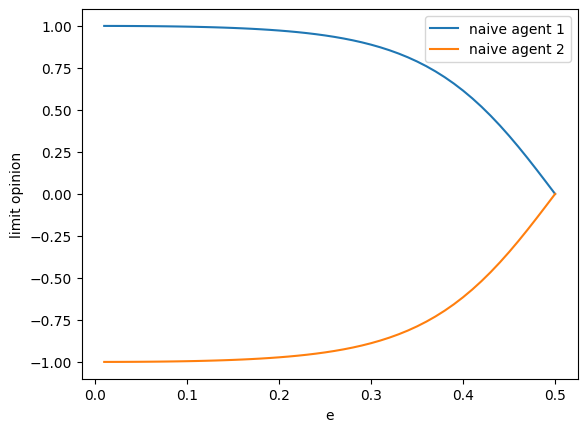

In [9]:
get_test_results(1.0)

A matrix:
[[0.99 0.01]
 [0.01 0.99]]

TEST 1: e = 0.01
limit opinion:
[[ 1.00577978 -1.00577978]]

K1:
[[1.5826145  0.00845234]
 [0.00845234 1.18163697]]

K2:
[[1.18163697 0.00845234]
 [0.00845234 1.5826145 ]]

limit messages:
strategic agent 1: [[0.02060912]
 [0.0287429 ]]
strategic agent 2: [[-0.0287429 ]
 [-0.02060912]]


TEST 2: e = 0.5
limit opinion:
[[0. 0.]]

K1:
[[1.65888741 0.01594974]
 [0.01594974 1.65888741]]

K2:
[[1.65888741 0.01594974]
 [0.01594974 1.65888741]]

limit messages:
strategic agent 1: [[1.53376187]
 [1.53376187]]
strategic agent 2: [[-1.53376187]
 [-1.53376187]]




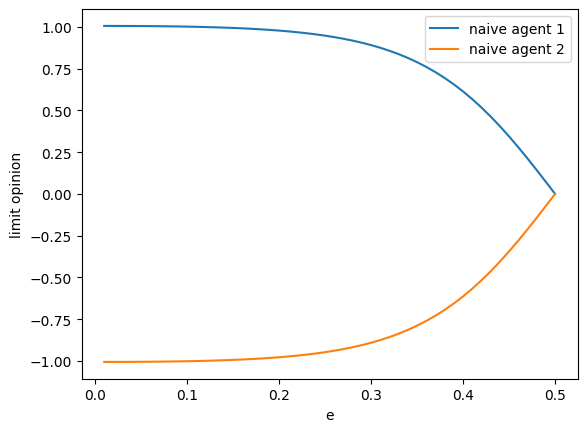

In [10]:
get_test_results(0.99)

A matrix:
[[0.9 0.1]
 [0.1 0.9]]

TEST 1: e = 0.01
limit opinion:
[[ 1.04733788 -1.04733788]]

K1:
[[1.46926166 0.07556684]
 [0.07556684 1.16860651]]

K2:
[[1.16860651 0.07556684]
 [0.07556684 1.46926166]]

limit messages:
strategic agent 1: [[0.21187362]
 [0.02873087]]
strategic agent 2: [[-0.02873087]
 [-0.21187362]]


TEST 2: e = 0.5
limit opinion:
[[0. 0.]]

K1:
[[1.53690975 0.13792739]
 [0.13792739 1.53690975]]

K2:
[[1.53690975 0.13792739]
 [0.13792739 1.53690975]]

limit messages:
strategic agent 1: [[1.53376187]
 [1.53376187]]
strategic agent 2: [[-1.53376187]
 [-1.53376187]]




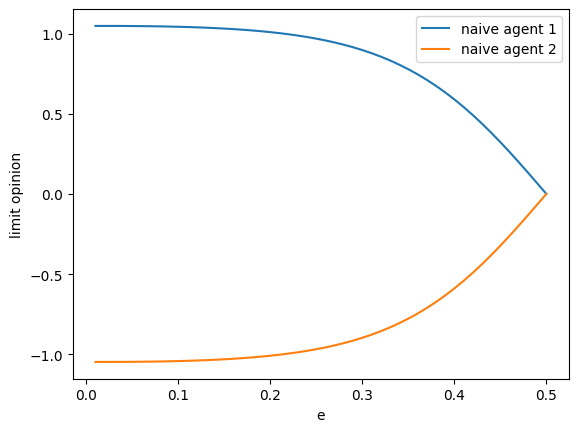

In [11]:
get_test_results(0.9)

A matrix:
[[0.7 0.3]
 [0.3 0.7]]

TEST 1: e = 0.01
limit opinion:
[[ 1.06721769 -1.06721769]]

K1:
[[1.29261141 0.17181707]
 [0.17181707 1.16846383]]

K2:
[[1.16846383 0.17181707]
 [0.17181707 1.29261141]]

limit messages:
strategic agent 1: [[0.64708713]
 [0.0285644 ]]
strategic agent 2: [[-0.0285644 ]
 [-0.64708713]]


TEST 2: e = 0.5
limit opinion:
[[0. 0.]]

K1:
[[1.38136235 0.29347479]
 [0.29347479 1.38136235]]

K2:
[[1.38136235 0.29347479]
 [0.29347479 1.38136235]]

limit messages:
strategic agent 1: [[1.53376187]
 [1.53376187]]
strategic agent 2: [[-1.53376187]
 [-1.53376187]]




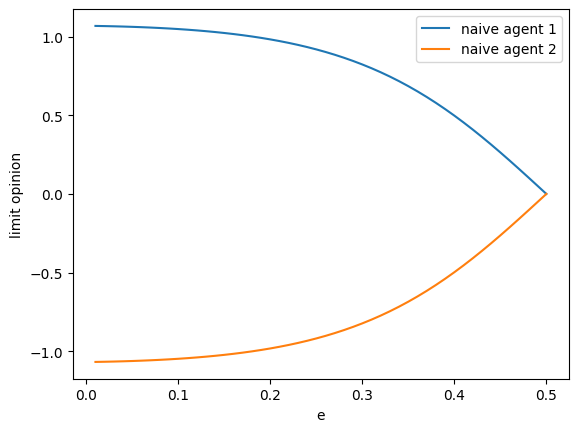

In [12]:
get_test_results(0.7)

A matrix:
[[0.6 0.4]
 [0.4 0.6]]

TEST 1: e = 0.01
limit opinion:
[[ 1.04415376 -1.04415376]]

K1:
[[1.23862215 0.19555008]
 [0.19555008 1.18166208]]

K2:
[[1.18166208 0.19555008]
 [0.19555008 1.23862215]]

limit messages:
strategic agent 1: [[0.84404802]
 [0.02845345]]
strategic agent 2: [[-0.02845345]
 [-0.84404802]]


TEST 2: e = 0.5
limit opinion:
[[0. 0.]]

K1:
[[1.34803017 0.32680698]
 [0.32680698 1.34803017]]

K2:
[[1.34803017 0.32680698]
 [0.32680698 1.34803017]]

limit messages:
strategic agent 1: [[1.53376187]
 [1.53376187]]
strategic agent 2: [[-1.53376187]
 [-1.53376187]]




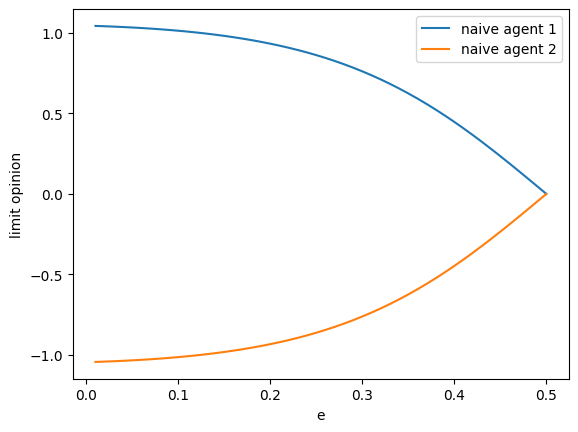

In [13]:
get_test_results(0.6)

A matrix:
[[0.5 0.5]
 [0.5 0.5]]

TEST 1: e = 0.01
limit opinion:
[[ 1.00521786 -1.00521786]]

K1:
[[1.2043418 0.2043418]
 [0.2043418 1.2043418]]

K2:
[[1.2043418 0.2043418]
 [0.2043418 1.2043418]]

limit messages:
strategic agent 1: [[1.01565797]
 [0.02835309]]
strategic agent 2: [[-0.02835309]
 [-1.01565797]]


TEST 2: e = 0.5
limit opinion:
[[0. 0.]]

K1:
[[1.33741857 0.33741857]
 [0.33741857 1.33741857]]

K2:
[[1.33741857 0.33741857]
 [0.33741857 1.33741857]]

limit messages:
strategic agent 1: [[1.53376187]
 [1.53376187]]
strategic agent 2: [[-1.53376187]
 [-1.53376187]]




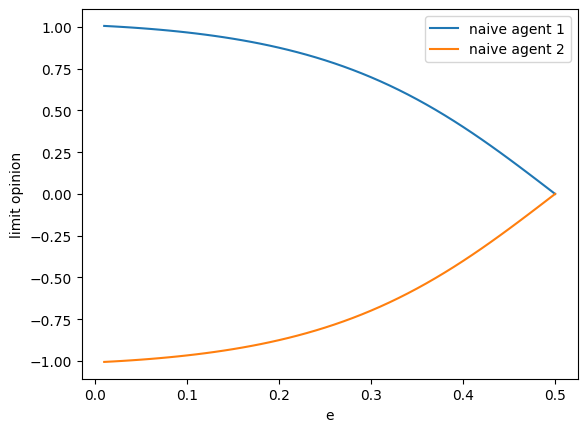

In [14]:
get_test_results(0.5)

A matrix:
[[0.3 0.7]
 [0.7 0.3]]

TEST 1: e = 0.01
limit opinion:
[[ 0.89821531 -0.89821531]]

K1:
[[1.1890455  0.17667054]
 [0.17667054 1.28587072]]

K2:
[[1.28587072 0.17667054]
 [0.17667054 1.1890455 ]]

limit messages:
strategic agent 1: [[1.2704888 ]
 [0.02824845]]
strategic agent 2: [[-0.02824845]
 [-1.2704888 ]]


TEST 2: e = 0.5
limit opinion:
[[0. 0.]]

K1:
[[1.38136235 0.29347479]
 [0.29347479 1.38136235]]

K2:
[[1.38136235 0.29347479]
 [0.29347479 1.38136235]]

limit messages:
strategic agent 1: [[1.53376187]
 [1.53376187]]
strategic agent 2: [[-1.53376187]
 [-1.53376187]]




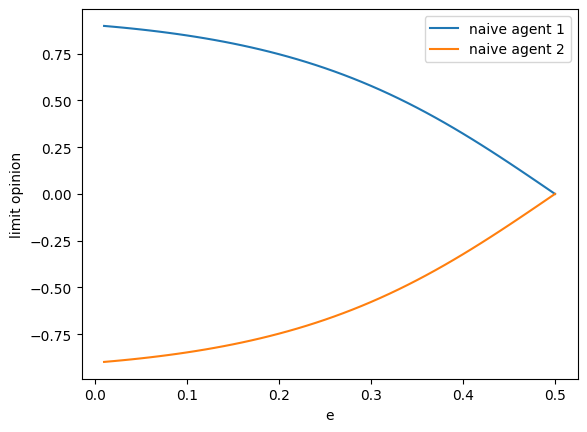

In [15]:
get_test_results(0.3)

In [16]:
xs_res_grid = []
A_11_test = 0.01
b1_test = 1
b2_test = -1
e_test_4 = 0.01
for A_11_test in np.linspace(0.0, 1.0, 50):
    A_data = np.array([
        [A_11_test, 1 - A_11_test],
        [1 - A_11_test, A_11_test]
    ])
    xs_4, rs_4, payoffs_4, historical_K_4 = run_simulation(A_data, X_0_1_numpy, b1_test, b2_test, e_test_4)
    xs_res_grid.append(xs_4[0][-1] + b1_test)

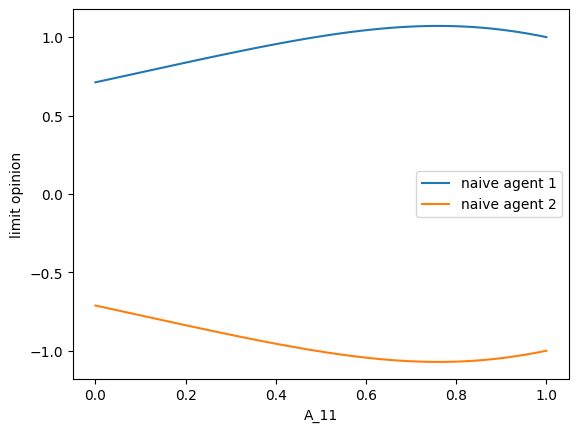

In [17]:
plt.plot(np.linspace(0.0, 1.0, 50), [xs_res[0][0] for xs_res in xs_res_grid], label = "naive agent 1")
plt.plot(np.linspace(0.0, 1.0, 50), [xs_res[1][0] for xs_res in xs_res_grid], label = "naive agent 2")
plt.xlabel("A_11")
plt.ylabel("limit opinion")
plt.legend()
plt.show()